In [1]:
import random
import time

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
import numpy as np

import zmq

from tensorflow.python.training import moving_averages

In [4]:
np.set_printoptions(precision=4, suppress=True)

In [5]:
import learner
reload(learner)

<module 'learner' from 'learner.pyc'>

In [6]:
exp_socket_addr = "tcp://127.0.0.1:19884"
max_actions = 7
strat_socket_addr = "tcp://127.0.0.1:19885"

In [6]:
context = zmq.Context()
sock_exp = context.socket(zmq.REP)
sock_exp.bind(exp_socket_addr)

In [7]:
sock_strat = context.socket(zmq.PUB)
sock_strat.bind(strat_socket_addr)

In [131]:
NUM_HIDDEN = 256

In [132]:
NUM_UNIT_REPRESENTATION = 100
N_UNIT = 36
N_ME = 32
EN_CNT = 10
FR_CNT = 10
N_REST = 809 - N_ME - (EN_CNT + FR_CNT) * N_UNIT

def CreateNetwork(state, num_actions, scope, is_training, reuse=False, dropout=True):
    with tf.variable_scope(scope, reuse=reuse):
        my_state = tf.slice(state, [0, 0], [-1, N_ME + EN_CNT * N_UNIT])
        rest_state = tf.slice(state, [0, 809 - N_REST], [-1, N_REST])
        
        with tf.variable_scope('friends'):
            friends = tf.reshape(tf.slice(state, [0, N_ME + EN_CNT * N_UNIT],
                                          [-1, FR_CNT * N_UNIT]), [-1, 1, FR_CNT, N_UNIT])
            friends = tf.contrib.layers.conv2d(
                friends, NUM_UNIT_REPRESENTATION,
                [1, 1], stride=1, activation_fn=tf.nn.elu)
            friends = tf.squeeze(tf.contrib.layers.max_pool2d(friends, [1, FR_CNT]), [1, 2])
        final_state = tf.concat(1, [my_state, friends, rest_state])

        hidden1 = tf.contrib.layers.fully_connected(
            final_state, NUM_HIDDEN,
            activation_fn=tf.nn.elu,
            weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
            biases_initializer=tf.constant_initializer(0.01),
            scope='hidden1', reuse=reuse)

        if dropout:
            do1 = tf.contrib.layers.dropout(hidden1, keep_prob=0.5, is_training=is_training)
        else:
            do1 = hidden1

        hidden2 = tf.contrib.layers.relu(
            do1, NUM_HIDDEN,
            activation_fn=tf.nn.elu,
            weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
            biases_initializer=tf.constant_initializer(0.01),
            scope='hidden2', reuse=reuse)

        if dropout:
            do2 = tf.contrib.layers.dropout(hidden2, keep_prob=0.5, is_training=is_training)
        else:
            do2 = hidden2

        value = tf.contrib.layers.linear(do2, 1,
                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                         biases_initializer=tf.constant_initializer(0.),
                                         scope='value')
        adv = tf.contrib.layers.linear(hidden2, num_actions,
                                       weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                       scope='advantage')
        adv = tf.sub(adv, tf.reduce_mean(adv, reduction_indices=1, keep_dims=True), 'advantage')

        output = tf.add(value, adv, 'output')
    return final_state, hidden1, hidden2, value, adv, output

In [36]:
def Select(value, index):
    # Value - float tensor of (batch, actions) size
    # index - int32 tensor of (batch) size
    # returns float tensor of batch size where in every batch the element from index is selected
    batch_size = tf.shape(value)[0]
    _range = tf.range(0, batch_size)
    ind = tf.concat(1, [tf.expand_dims(_range, 1), 
                        tf.expand_dims(index, 1)])
    return tf.gather_nd(value, ind)

In [37]:
def Select4(value, index):
    # Value - float tensor of (batch, actions) size
    # index - int32 tensor of (batch) size
    # returns float tensor of batch size where in every batch the element from index is selected
    shp = tf.shape(value)
    return tf.reduce_sum(value * tf.one_hot(index, shp[1]), reduction_indices=1)

In [26]:
DEFAULT_OPTIONS = {
    'clip_grad': 3.,
    'learning_rate': 0.001,
    'update_steps': 10000,
}

In [27]:
# Compute the normalization coefficients for state
# size = min(buf.inserted, buf.buffer_size)
# STATE_MEAN, STATE_STD = buf.ss[:, :size].mean(1), buf.ss[:, :size].std(1) + 0.01

In [350]:
class QLearner(object):
    def __init__(self, exp_buffer, num_actions, run_index, options=DEFAULT_OPTIONS):
        self.exp_buffer = exp_buffer
        self.num_actions = num_actions
        self.run_index = run_index
        self.options = options

        self.state = tf.placeholder(tf.float32, shape=[None, self.exp_buffer.state_size], name='state')
        self.action = tf.placeholder(tf.int32, shape=[None], name='action')
        self.reward = tf.placeholder(tf.float32, shape=[None], name='reward')
        self.state1 = tf.placeholder(tf.float32, shape=[None, self.exp_buffer.state_size], name='state1')
        self.gamma = tf.placeholder(tf.float32, shape=[None], name='gamma')
        self.is_weights = tf.placeholder(tf.float32, shape=[None], name='is_weights')       
        self.is_training = tf.placeholder(tf.bool, shape=None, name='is_training')

#         mean = tf.get_variable('mean', dtype=tf.float32,
#                                initializer=STATE_MEAN, trainable=False)
#         std = tf.get_variable('std', dtype=tf.float32,
#                               initializer=STATE_STD, trainable=False)       
        
#         norm_state = (self.state - tf.identity(mean)) / tf.identity(std)
#         norm_state1 = (self.state1 - mean) / std
        norm_state = self.state
        norm_state1 = self.state1

        self.pred_vars = CreateNetwork(norm_state, num_actions, 'model', self.is_training)
        self.pred_vars_s1 = CreateNetwork(norm_state1, num_actions, 'model', self.is_training, True)
        self.target_vars = CreateNetwork(norm_state1, num_actions, 'target', False)
        
        self.vars_pred = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'model')
        self.vars_target = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'target')
        
        self.copy_op = tf.group(
            *[tf.assign(y, x) for x, y in zip(self.vars_pred, self.vars_target)]
        )
#         self.vars_pred.extend([mean, std])

        idx = len(self.pred_vars) - 1

        self.act_s1 = tf.cast(tf.argmax(self.pred_vars_s1[idx], dimension=1), tf.int32)
        self.q_s1 = Select(self.target_vars[idx], self.act_s1)
        self.target_q = tf.stop_gradient(self.reward + self.gamma * self.q_s1)
        self.q = Select4(self.pred_vars[idx], self.action)

        self.delta = self.target_q - self.q
        self.td_err_weight = tf.abs(self.delta)
        self.loss = tf.reduce_mean(learner.HuberLoss(self.delta, 5) * self.is_weights)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        
        optimizer = tf.train.AdamOptimizer(options['learning_rate'])
        grads = optimizer.compute_gradients(self.loss, tf.get_collection(
                tf.GraphKeys.TRAINABLE_VARIABLES, 'model'))
        if 'clip_grad' in options:
            gg = [g for g, _ in grads]
            vv = [v for _, v in grads]
            global_norm = tf.global_norm(gg)
            tf.scalar_summary('Scalars/Grad norm', global_norm)
            grads = zip(tf.clip_by_global_norm(gg, options['clip_grad'], global_norm)[0], vv)
#             grads = [(tf.clip_by_norm(g, options['clip_grad']) if g is not None else None, v)
#                      for g, v in grads]

        for grad, v in grads:
            if grad is not None:
                tf.histogram_summary('{}/grad'.format(v.name), grad)
                
        for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
            tf.histogram_summary(v.name, v)

        for ten in self.pred_vars:
            tf.histogram_summary('vars/' + ten.name, ten)

        tf.histogram_summary('Monitor/TD Error', self.delta)
        tf.histogram_summary('Monitor/Q', self.q)
        tf.histogram_summary('Monitor/Weights', self.is_weights)
        tf.scalar_summary("Scalars/Loss", self.loss)
        tf.scalar_summary("Scalars/Q Func", tf.reduce_mean(self.q))
        tf.scalar_summary('Scalars/Weights', tf.reduce_mean(self.is_weights))
            
        self.train_op = optimizer.apply_gradients(grads, self.global_step)
#         if update_ops:
        self.train_op = tf.group(#tf.add_check_numerics_ops(), 
                                 self.train_op, #self.mean_update, self.var_update,
                                 *update_ops)

        self.summary_op = tf.merge_all_summaries()
        self.writer = None
        self.saver = None
        self.cur_step = None

    def step(self, sess, batch_size=32):
        idx, ss, aa, rr, ss1, gg, ww = self.exp_buffer.sample(batch_size)
        if ss is None:
            return
        
        if self.writer is None:
            self.writer = tf.train.SummaryWriter('/Users/vertix/tf/tensorflow_logs/aicup/%s'
                                                 #'/media/vertix/UHDD/tmp/tensorflow_logs/aicup/%s'
                                                 % self.run_index)
            self.saver = tf.train.Saver(self.vars_pred)
            self.last_start = time.time()

        feed_dict = {self.state: ss, self.action: aa, self.reward: rr, self.state1:ss1,
                     self.gamma: gg, self.is_weights: ww,
                     self.is_training: True}

        if self.cur_step and self.cur_step % 100 != 0:
            self.cur_step, weights, _ = sess.run(
                [self.global_step, self.td_err_weight, self.train_op], feed_dict)
        else:
            self.cur_step, weights, _, smr = sess.run(
                [self.global_step, self.td_err_weight, self.train_op, self.summary_op], feed_dict)
            self.writer.add_summary(smr, self.cur_step)
        
        for ii, td_w in zip(idx, weights):
            self.exp_buffer.tree_update(ii, td_w)
            
        if self.cur_step % self.options['update_steps'] == 0:
            print 'Updated target network'
            sess.run(self.copy_op)
            self.saver.save(sess, self.run_index, global_step=self.global_step)
            if self.last_start is not None:
                self.writer.add_summary(
                    tf.Summary(
                        value=[tf.Summary.Value(
                                tag='Steps per sec',
                                simple_value=self.options['update_steps'] / (time.time() - self.last_start))]),
                    self.cur_step)
            self.last_start = time.time()

    def stat(self, data):
        self.writer.add_summary(
            tf.Summary(
                value=[tf.Summary.Value(tag=name, simple_value=value)
                       for name, value in data.items()]), self.cur_step)

In [137]:
buf = learner.WeightedExperienceBuffer(0.6, 0.4, 100, buffer_size=1<<18)
for _ in range(2):
    msg = sock_exp.recv_pyobj()
    sock_exp.send('Ok')
    if msg['type'] == 'exp':
        msg = msg['data']
        buf.add(msg['s'], msg['a'], msg['r'], msg['s1'], msg['g'], 100)

In [138]:
buf.inserted, buf.buffer_size

(40, 262144)

In [104]:
for i in xrange(min(buf.buffer_size, buf.inserted)):
    buf.tree_update(i, 100)

In [108]:
buf.beta = 0.7

Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network
Updated target network


In [235]:
tf.reset_default_graph()

In [236]:
state = tf.placeholder(tf.float32, shape=[None, 809], name='state')

In [237]:
fs, h1, _, _, _, _ = CreateNetwork(state, 4 + 5, 'model', False)
# fs = CreateNetwork(state, 4 + 5, 'model', False)

(?, 392)
(?, 57)
(?, 64)


In [145]:
# enemies = tf.transpose(
enemies = tf.reshape(tf.slice(state, [0, 32], [-1, 10 * 36]), [-1, 1, 10, 36])
#     [0, 1, 3, 2])

In [146]:
enemies_repr = tf.contrib.layers.conv2d(enemies, 10, [1, 1], stride=1, activation_fn=tf.nn.elu)

In [147]:
enemies_summary = tf.squeeze(tf.contrib.layers.max_pool2d(enemies_repr, [1, 10]))

In [148]:
enemies_indexes = tf.argmax(enemies_repr, 2)

In [196]:
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count = {'GPU': 0}))
sess.run(tf.initialize_all_variables())

In [197]:
fs.eval({state: buf.ss[:, :2].transpose()}).shape

(2, 465)

In [150]:
enemies.eval({state: buf.ss[:, :2].transpose()}).shape

(2, 1, 10, 36)

In [151]:
enemies_repr.eval({state: buf.ss[:, :2].transpose()}).shape

(2, 1, 10, 10)

In [153]:
enemies_summary.eval({state: buf.ss[:, :2].transpose()})

array([[ 4.805,  0.   ,  9.333,  0.637,  0.   ,  3.134,  2.208,  0.   ,
         5.666,  2.19 ],
       [ 4.805,  0.   ,  9.33 ,  0.637,  0.   ,  3.131,  2.21 ,  0.   ,
         5.669,  2.19 ]], dtype=float32)

In [140]:
enemies_indexes.eval({state: buf.ss[:, :2].transpose()})

array([[[2, 6, 6, 6, 1, 7, 7, 6, 3, 6]],

       [[2, 6, 6, 6, 1, 7, 7, 6, 3, 6]]])

In [103]:
enemies_repr.eval({state: buf.ss[:, :2].transpose()})

array([[[[-0.78 , -0.95 ,  1.733,  1.419, -0.938,  0.907, -0.496,  2.993,
           0.129,  0.763],
         [-0.806, -0.974,  2.213,  0.988, -0.862,  0.82 , -0.29 ,  3.333,
           0.941, -0.17 ],
         [-0.81 , -0.93 ,  2.08 ,  1.462, -0.865,  0.972, -0.202,  3.062,
           0.753,  0.572],
         [-0.433, -0.886,  1.815,  2.02 , -0.914,  0.923,  0.45 ,  3.668,
           0.723,  0.41 ],
         [-0.572, -0.899,  2.133,  1.941, -0.87 ,  0.879,  0.48 ,  3.525,
           0.99 ,  0.215],
         [-0.801, -0.948,  2.288,  1.316, -0.748,  0.916,  0.302,  3.663,
           1.431, -0.043],
         [-0.611, -0.996,  4.215,  3.947, -0.965,  1.757, -0.366,  6.488,
           1.842,  0.89 ],
         [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
           0.   ,  0.   ],
         [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
           0.   ,  0.   ],
         [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
           0.   ,

In [95]:
for v in tf.get_collection(tf.GraphKeys.VARIABLES):
    print v.name
    print v.eval().shape

Conv/weights:0
(1, 1, 36, 10)
Conv/biases:0
(10,)


In [59]:
friends.eval({state: buf.ss[:, :2].transpose()}).shape

(2, 10, 36)

In [139]:
sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count = {'GPU': 0}))

In [140]:
ql = QLearner(buf, 4 + 5, run_index='ql-3-fr100-256', options={
    'clip_grad': 3.,
    'learning_rate': 0.001 / 4,
    'update_steps': 20000,
})
sess.run(tf.initialize_all_variables())

In [387]:
for _ in xrange(105):
    ql.step(sess)

3. Test Q-learning on simple task

In [119]:
for v in ql.vars_pred:
    print v.name

model/hidden1/weights:0
model/hidden1/biases:0
model/hidden2/weights:0
model/hidden2/biases:0
model/value/weights:0
model/value/biases:0
model/advantage/weights:0
model/advantage/biases:0
mean:0
std:0


In [62]:
import threading

In [169]:
def FillBuffer(ql, coord):
    while not coord.should_stop():
        msg = sock_exp.recv_pyobj()
        sock_exp.send('Ok')
    
        if msg['type'] == 'exp':
            msg = msg['data']
            ql.exp_buffer.add(msg['s'], msg['a'], msg['r'], msg['s1'], msg['g'], 100)
        elif msg['type'] == 'stat':
            ql.stat(msg['data'])        

In [64]:
def Learn(ql, coord, sess):
    i = 0
    while not coord.should_stop():
        ql.step(sess)
        
        if i > 0 and i % 500 == 0:
            sock_strat.send_pyobj({v.name: sess.run(v, {ql.is_training: False})
                                   for v in ql.vars_pred})
        i += 1

In [254]:
Learn(ql, coord, sess)

KeyboardInterrupt: 

In [197]:
coord = tf.train.Coordinator()

In [172]:
threads = [threading.Thread(target=FillBuffer, args=(ql, coord)),
           threading.Thread(target=Learn, args=(ql, coord, sess))]

In [176]:
threads[0].start()
threads[1].start()

In [193]:
coord.request_stop()

In [192]:
ql.cur_step, ql.exp_buffer.inserted

(939023, 125780)

In [194]:
def FillBufferSimple(coord, buf):
    while not coord.should_stop():
        msg = sock_exp.recv_pyobj()
        sock_exp.send('Ok')
    
        if msg['type'] == 'exp':
            msg = msg['data']
            buf.add(msg['s'], msg['a'], msg['r'], msg['s1'], msg['g'], 100)

In [ ]:
FillBufferSimple(coord, buf)

In [23]:
import threading
_t = threading.Thread(target=FillBufferSimple, args=(coord, buf))
_t.start()

-----------------------
## Debug

In [110]:
ql.pred_vars

(<tf.Tensor 'model/concat:0' shape=(?, 513) dtype=float32>,
 <tf.Tensor 'model/hidden1/Elu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'model/hidden2/Elu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'model/value/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'model/advantage_1:0' shape=(?, 9) dtype=float32>,
 <tf.Tensor 'model/output:0' shape=(?, 9) dtype=float32>)

In [111]:
value = ql.pred_vars[3]

In [112]:
dv_ds = tf.gradients(value, ql.state)
dv_ds = dv_ds[0]

In [115]:
value.eval({ql.state: ss, ql.is_training: False})

array([[ 10.8584]], dtype=float32)

In [116]:
dv_ds_val = dv_ds.eval({ql.state: ss1, ql.is_training: False})

In [117]:
dv_ds_val_scaled = dv_ds_val / (buf.ss.std(axis=1) + 0.001)

In [118]:
np.abs(dv_ds_val_scaled).argsort()[0, -20:]

array([ 28, 677, 427, 453, 793, 209, 782, 804,  16, 444, 461, 418, 425,
       415, 405, 410, 403, 404,  11, 408])

In [126]:
def PlotValue(sess, ql, ss, i, start, stop):
    value = ql.pred_vars[3]
    n = 500
    sss = ss.repeat(n, 0)
    vx = ss[:, i]
    space = np.linspace(start, stop, n)
    sss[:, i] = space
    plt.plot(space, sess.run(value, {ql.state: sss, ql.is_training: False}), 'b-',
             vx, sess.run(value, {ql.state: ss, ql.is_training: False}), 'ro')

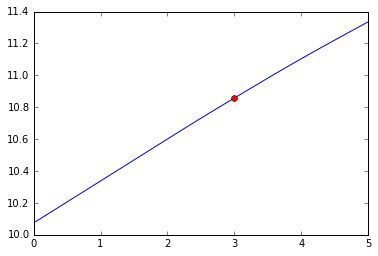

In [130]:
PlotValue(sess, ql, ss, 28, 0., 5.)

In [137]:
enemies_indexes = tf.argmax(enemies_repr, 2)

In [113]:
idx, ss, aa, rr, ss1, gg, ww = buf.sample(1)

In [114]:
ss

array([[  0.75  ,   1.1   ,   1.05  ,   1.1   ,   0.2548,   1.142 ,
          0.7262,  -3.9236,   4.    ,  -1.3878,   0.545 ,   0.6   ,
          0.08  ,   1.    ,   0.    ,   0.    ,   0.6   ,   5.45  ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   1.2   ,
          0.8   ,  15.    ,   0.055 ,   4.    ,   3.    ,   9.    ,
          0.    ,   0.    ,   1.    ,   1.    ,   0.    ,   0.    ,
          0.2302,   0.942 ,   2.5   ,   0.3473,   2.9798,   3.    ,
          1.4489,  -0.0245,  -0.2   ,  -0.3789,   2.2536,  -0.305 ,
          0.2015,   0.085 ,   0.4   ,   0.    ,   1.    ,   0.    ,
          0.    ,   0.6   ,   0.85  ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          3.    ,   0.    ,   0.52  ,   1.    ,   0.    ,   0.    ,
          0.1682,   0.9177,   2.5   ,   0.    ,   0.    ,   3.    ,
          1.2027,  -0.0865,  -0.2243,  -0.7262,  -0.7262,  -0.5512,
          0.2405,   0.34  ,   0.4   ,   0.16  , 

-----------------

-------------------
Use OpenAI env to test Q-Learning

In [74]:
import gym

In [394]:
env = gym.make('MountainCar-v0')

[2016-12-17 22:27:03,203] Making new env: MountainCar-v0


In [395]:
env.action_space

Discrete(3)

In [396]:
ROLLOUT_LEN = 20
GAMMA = 0.99

In [397]:
buf = learner.WeightedExperienceBuffer(0.6, 0.4, 100, 1 << 18)
old_s = env.reset()
for _ in range(50):
    ss, aa, rr, ss1, gg = [], [], [], [], []
    done = False
    while not done and len(ss) < ROLLOUT_LEN:
        a = env.action_space.sample()
    
        s, r, done, _ = env.step(a)
        ss.append(old_s)
        aa.append(a)
        rr.append(r)
        ss1.append(s)
        gg.append(GAMMA if not done else 0.)

        old_s = s
    
    rew = 0.
    g = 1.
    for i in reversed(range(len(ss))):
        rew = rr[i] + gg[i] * rew
        g *= gg[i]
        ss1[i] = old_s
        rr[i] = r
        gg[i] = g
    
    if done:
        old_s = env.reset()
    
    buf.add(np.array(ss), np.array(aa), np.array(rr), np.array(ss1), np.array(gg), 100)

In [398]:
NUM_HIDDEN = 128
def CreateNetwork(state, num_actions, scope, is_training, reuse=False, dropout=False):
    with tf.variable_scope(scope, reuse=reuse):
        hidden1 = tf.contrib.layers.fully_connected(
            state, NUM_HIDDEN,
            activation_fn=tf.nn.elu,
            weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
            biases_initializer=tf.constant_initializer(0.01),
            scope='hidden1', reuse=reuse)

        if dropout:
            do1 = tf.contrib.layers.dropout(hidden1, keep_prob=0.5, is_training=is_training)
        else:
            do1 = hidden1

        do2 = do1
#         hidden2 = tf.contrib.layers.relu(
#             do1, NUM_HIDDEN / 2,
#             activation_fn=tf.nn.elu,
#             weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
#             biases_initializer=tf.constant_initializer(0.01),
#             scope='hidden2', reuse=reuse)

#         if dropout:
#             do2 = tf.contrib.layers.dropout(hidden2, keep_prob=0.5, is_training=is_training)
#         else:
#             do2 = hidden2
            
        value = tf.contrib.layers.linear(do2, 1,
                                         weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                         biases_initializer=tf.constant_initializer(0.),
                                         scope='value')
        adv = tf.contrib.layers.linear(do2, num_actions,
                                       weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                       scope='advantage')
        adv = tf.sub(adv, tf.reduce_mean(adv, reduction_indices=1, keep_dims=True), 'advantage')

        output = tf.add(value, adv, 'output')
    return hidden1, value, adv, output
#     return hidden1, hidden2, value, adv, output

In [399]:
sess.close()
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [400]:
ql = QLearner(buf, env.action_space.n, 'mcar-1', options={
    'clip_grad': 3.,
    'learning_rate': 0.001 / 4,
    'update_steps': 15000,
    })
sess.run(tf.global_variables_initializer())

In [68]:
for v in ql.vars_pred:
    print v.name

model/hidden1/weights:0
model/hidden1/biases:0
model/hidden2/weights:0
model/hidden2/biases:0
model/value/weights:0
model/value/biases:0
model/advantage/weights:0
model/advantage/biases:0


In [62]:
for v in tf.get_collection(tf.GraphKeys.VARIABLES, 'model'):
    print v.name

In [315]:
0.3 / (1 + (ql.cur_step or 0.) / 500000.)

0.099758252501438174

In [ ]:
episode_rew = 0.
episode_len = 0.
old_s = env.reset()
for i in range(100500100):
    ss, aa, rr, ss1, gg = [], [], [], [], []
    done = False
    if i % 20 == 0:
        while not done and len(ss) < ROLLOUT_LEN:
            epsilon = 0.3 / (1 + (ql.cur_step or 0.) / 500000.)
            if np.random.sample() < epsilon:
                a = env.action_space.sample()
            else:
                a = sess.run(ql.act_s1, {ql.state1: np.reshape(old_s, (1, -1)),
                                         ql.is_training: False})
                a = a[0]

            s, r, done, _ = env.step(a)
#             if episode_len > 1500:
#                 r -= 1000
#                 done = True

            ss.append(old_s)
            aa.append(a)
            rr.append(r)
            ss1.append(s)
            gg.append(GAMMA if not done else 0.0)

            episode_rew += r
            episode_len += 1

            old_s = s

        rew = 0.
        g = 1.
        for i in reversed(range(len(ss))):
            rew = rr[i] + gg[i] * rew
            g *= gg[i]
            ss1[i] = old_s
            rr[i] = r
            gg[i] = g

        if done:
            ql.stat({'Env/Reward': episode_rew, 'Env/Lenght': episode_len})
            episode_rew, episode_len = 0., 0.
            old_s = env.reset()

        buf.add(np.array(ss), np.array(aa), np.array(rr), np.array(ss1), np.array(gg), 100)

    ql.step(sess)

Updated target network


In [280]:
ql.cur_step, buf.inserted

(5395630, 21034312)

In [187]:
buf.beta = 0.7

In [393]:
old_s = env.reset()
done = False
r = 0
while not done:
    env.render('human')
#     print old_s
    a = sess.run(ql.act_s1, {ql.state1: np.reshape(old_s, (1, -1)),
                             ql.is_training: False})
    old_s, reward, done, _ = env.step(a[0])
    r += reward
    
    if a < -1000:
        break
    
print r
env.render(close=True)

183.301092139


----------------

In [372]:
network_vars = {v.name: v.eval() for v in ql.vars_pred}

In [373]:
sorted(network_vars.keys())

[u'mean:0',
 u'model/advantage/biases:0',
 u'model/advantage/weights:0',
 u'model/friends/Conv/biases:0',
 u'model/friends/Conv/weights:0',
 u'model/hidden1/biases:0',
 u'model/hidden1/weights:0',
 u'model/hidden2/biases:0',
 u'model/hidden2/weights:0',
 u'model/value/biases:0',
 u'model/value/weights:0',
 u'std:0']

In [274]:
def Elu(x):
    return np.where(x < 0, np.exp(x) - 1, x)

In [275]:
def ReLu(x):
    return np.maximum(x, 0)

In [276]:
def Normalize(state, mean, std):
    return (state - mean) / std

def BatchNorm(state, network_vars, key, shift=True, eps=0.001):
    inv = 1.0 / np.sqrt(network_vars[key + '/moving_variance:0'] + eps)

    if shift:
        return state * inv + (network_vars[key + '/beta:0'] - network_vars[key + '/moving_mean:0'] * inv)
    else:
        return state * inv + (-network_vars[key + '/moving_mean:0'] * inv)

In [342]:
class QFunction(object):
    def __init__(self, network_vars):
        self.vars = network_vars

    def Q(self, state):
        state = Normalize(state, self.vars['mean:0'], self.vars['std:0'])
        
        my_state = state[:32 + 10 * 36]
        friends = state[32 + 10 * 36: 32 + 20 * 36].reshape((10, -1))
        friends = np.matmul(friends, self.vars['model/friends/Conv/weights:0'][0, 0, :, :])
        friends += self.vars['model/friends/Conv/biases:0']
        friends = Elu(friends)
        friends = friends.max(0)
        rest_state = state[32 + 20 * 36:]
        state = np.concatenate((my_state, friends, rest_state))

        state = np.matmul(state, self.vars['model/hidden1/weights:0'])
        state += self.vars['model/hidden1/biases:0']
        state = Elu(state)

        state = np.matmul(state, self.vars['model/hidden2/weights:0'])
        state += self.vars['model/hidden2/biases:0']
        state = Elu(state)

        value = np.matmul(state, self.vars['model/value/weights:0'])
        value += self.vars['model/value/biases:0']

        adv = np.matmul(state, self.vars['model/advantage/weights:0'])
        adv += self.vars['model/advantage/biases:0']

        return value + (adv - adv.mean(keepdims=True))
        return value + (adv - adv.mean(1, keepdims=True))

In [289]:
friends = ss[32 + 10 * 36: 32 + 20 * 36]

In [296]:
friends = friends.reshape((10, -1))

In [298]:
friends.shape

(10, 36)

In [265]:
network_vars['model/friends/Conv/weights:0'].shape

(1, 1, 36, 64)

In [305]:
friends = np.matmul(friends, network_vars['model/friends/Conv/weights:0'][0, 0, :, :])

In [308]:
friends += network_vars['model/friends/Conv/biases:0']

In [310]:
friends.max(0).shape

(64,)

In [279]:
ss.reshape((5, -1))

ValueError: total size of new array must be unchanged

In [266]:
_, ss, aa, rr, ss1, gg, ww = ql.exp_buffer.sample(1)

In [270]:
ss = ss[0, :]

In [374]:
ql.pred_vars

(<tf.Tensor 'model/concat:0' shape=(?, 513) dtype=float32>,
 <tf.Tensor 'model/hidden1/Elu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'model/hidden2/Elu:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'model/value/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'model/advantage_1:0' shape=(?, 7) dtype=float32>,
 <tf.Tensor 'model/output:0' shape=(?, 7) dtype=float32>)

In [375]:
ql.pred_vars[5].eval({ql.state: ss.reshape((1, -1)), ql.is_training: False})

array([[-0.0042, -0.0008, -0.0029,  0.0015, -0.0015,  0.0022,  0.0014]], dtype=float32)

In [376]:
QFunction(network_vars).Q(ss)

array([-0.0042, -0.0008, -0.0029,  0.0015, -0.0015,  0.0022,  0.0014], dtype=float32)

In [170]:
ql.q.eval(feed_dict)

array([ 1746.92163086,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,  3156.87939453], dtype=float32)

In [174]:
ql.q_s1.eval(feed_dict)

array([ 10.50465488,  10.50465488,  10.50465488,  10.50465488,
        10.50465488,  10.50465488,  10.50465488,  10.50465488,
        10.50465488,  10.50465488], dtype=float32)

In [173]:
sess.run(ql.copy_op)

In [138]:
Select(ql.pred_vars[2], ql.action).eval(feed_dict)

array([ 2186.74389648,  6496.70410156,  2797.15771484,  4662.953125  ,
           0.        ,  2761.18579102,  3284.98608398,  6556.95996094,
        2748.39379883,     0.        ], dtype=float32)

In [148]:
tf.reduce_sum(ql.pred_vars[2] * tf.one_hot(ql.action, ql.num_actions), reduction_indices=1).eval(feed_dict)

array([ 2186.74389648,  6496.70410156,  2797.15771484,  4662.953125  ,
           0.        ,  2761.18579102,  3284.98608398,  6556.95996094,
        2748.39379883,     0.        ], dtype=float32)

In [93]:
tf.shape(ql.pred_vars[2]).eval(feed_dict)

array([10,  7], dtype=int32)

In [51]:
ql.delta.eval()

array([ 25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,  25.], dtype=float32)

In [40]:
tf.reduce_mean(ql.delta).eval({ql.state: ss, ql.action: aa, ql.reward: rr, ql.state1:ss1, ql.gamma: gg})

25.0

In [283]:
ql.q.eval({ql.state: ss, ql.action: aa})

array([    0.        ,     0.        ,  2561.84985352,  2696.66064453,
        3319.86474609,  2376.26171875,  2375.80859375,  2602.42016602,
        2548.83056641,     0.        ], dtype=float32)

In [284]:
ql.q_s1.eval({ql.state1: ss1})

array([ 9.87346268,  9.87346268,  9.87346268,  9.87346268,  9.87346268,
        9.87346268,  9.87346268,  9.87346268,  9.87346268,  9.87346268], dtype=float32)